In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ratings = pd.read_csv('./Raw Data/ratings_small.csv')
movies = pd.read_csv('./Raw Data/movies_small.csv')
df = pd.merge(ratings, movies, on='movieId', how='left')

In [3]:
df.head(5)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [4]:
df['year'] = df['title'].str.extract('.*\((.*)\).*',expand = False)

In [5]:
df['title'] = df['title'].str[:-7]

To figure out top 250 movies, we need to calculate the weighted rating

WeightedRating(WR)=(v / v+m)⋅R + (m / v+m)⋅C

v: number of ratings for each movie

m: minimum votes required to be listed in the chart

R: average rating of the movie

C: mean vote across the whole report

In [6]:
df = pd.merge(df, movies, on='movieId', how='left')

In [7]:
#v = 'count'
df_count = df.groupby('movieId').count()[['userId']].rename(columns={'userId' : 'count'}).reset_index()
df = pd.merge(df, df_count, on='movieId', how='left')

In [8]:
#R = 'avg_rating'
df_rating = df.groupby('movieId')[['rating']].mean().rename(columns={'rating' : 'avg_rating'}).reset_index()
df = pd.merge(df, df_rating, on='movieId', how='left')

In [9]:
#C = mean of 'avg_rating'
C = df['avg_rating'].mean()

In [10]:
#m
#cutoff is arbitrary
m = df['count'].quantile(0.8)

In [11]:
#make new dataframe with m 
popular_movies = df.copy().loc[df['count']>=m]
print(f'# ratings with quantile: {popular_movies.shape[0]}')
print(f'Difference in # ratings from og: {df.shape[0] - popular_movies.shape[0]}')

# ratings with quantile: 20188
Difference in # ratings from og: 80648


### Weighted Average

Referencing equation above: WeightedRating(WR)=(v / v+m)⋅R + (m / v+m)⋅C

In [12]:
popular_movies.columns
popular_movies.drop(columns=['title_x','genres_x'], inplace=True)
popular_movies.rename(columns={'genres_y':'genres', 'title_y':'title'}, inplace=True)

In [13]:
def weighted_rating(df, m=m, C=C):
    v = df['count']
    R = df['avg_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [14]:
#new column with weighted averages
popular_movies['weighted_avg'] = df.apply(weighted_rating, axis=1)

In [15]:
popular_movies.sort_values('weighted_avg', ascending=False, inplace=True)

In [16]:
popular_movies.drop_duplicates(subset=['title'], inplace=True)
popular_movies[['title', 'weighted_avg', 'count', 'avg_rating']].head(20)

,title,weighted_avg,count,avg_rating
19186,"Shawshank Redemption, The (1994)",4.206608,317,4.429022
90892,Fight Club (1999),4.030364,218,4.272936
61425,Pulp Fiction (1994),4.026181,307,4.197068
71518,Star Wars: Episode IV - A New Hope (1977),4.023236,251,4.231076
56800,"Godfather, The (1972)",4.019369,192,4.289062
15156,Forrest Gump (1994),4.009687,329,4.164134
44687,"Matrix, The (1999)",4.009671,278,4.192446
80084,Schindler's List (1993),3.998924,220,4.225000
87088,"Usual Suspects, The (1995)",3.995578,204,4.237745
39342,"Silence of the Lambs, The (1991)",3.987218,279,4.161290


### Web scraping for top imdb list

In [17]:
import requests
from bs4 import BeautifulSoup
import time
import re

In [18]:
url = 'http://www.imdb.com/chart/top'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'lxml')

In [19]:
titles = soup.select('td.titleColumn')
ratings = [b.attrs.get('data-value') for b in soup.select('td.posterColumn span[name=ir]')]

In [20]:
top_list = []
top100_titles_imdb = []
all_titles_imdb = []
for index in range(0, len(titles)):
    movie_string = titles[index].get_text()
    movie = (' '.join(movie_string.split()).replace('.', ''))
    movie_title = movie[len(str(index))+1:-7]
    year = re.search('\((.*?)\)', movie_string).group(1)
    rank = movie[:len(str(index))-(len(movie))]
     
    data = {"movie_title": movie_title,
            "year": year,
            "rank": rank,
            "rating": ratings[index]}
    top_list.append(data)
    all_titles_imdb.append(movie_title + ' (' + year + ')')
    if int(rank) <= 100:
        top100_titles_imdb.append(movie_title + ' (' + year + ')')

In [21]:
imdb = pd.DataFrame(top_list)
imdb.head(2)

,movie_title,year,rank,rating
0,The Shawshank Redemption,1994,1,9.233467978052047
1,The Godfather,1972,2,9.155448856067846


In [22]:
#imdb_top.to_csv('imdb_250')

## How does this list compare to imdb's top 100?

In [23]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [24]:
df_top = [title for title in popular_movies['title'].head(100)]
intersection(df_top, top100_titles_imdb)

['Fight Club (1999)',
 'Pulp Fiction (1994)',
 'Forrest Gump (1994)',
 "Schindler's List (1993)",
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Saving Private Ryan (1998)',
 'Goodfellas (1990)',
 'American History X (1998)',
 "One Flew Over the Cuckoo's Nest (1975)",
 'Reservoir Dogs (1992)',
 'Memento (2000)',
 'Eternal Sunshine of the Spotless Mind (2004)',
 'Braveheart (1995)',
 'American Beauty (1999)',
 'Apocalypse Now (1979)',
 'Casablanca (1942)',
 'Back to the Future (1985)',
 'Good Will Hunting (1997)',
 'Inception (2010)',
 'Terminator 2: Judgment Day (1991)',
 'Toy Story (1995)',
 'WALL·E (2008)',
 'Alien (1979)',
 'Gladiator (2000)',
 'Aliens (1986)',
 '2001: A Space Odyssey (1968)']

In [25]:
print(f'Percent of overlapping top 100: {len(intersection(df_top, top100_titles_imdb))}%')

Percent of overlapping top 100: 27%


In [26]:
imdb = pd.DataFrame(top_list)
imdb['rank'] = imdb['rank'].astype(int)
imdb['year'] = imdb['year'].astype(int)
imdb_top100 = imdb[imdb['rank']<=100]

In [27]:
df_top100 = popular_movies.copy()[['title', 'year', 'weighted_avg']].head(100)
df_top100['year'] = df_top100['year'].astype(int)

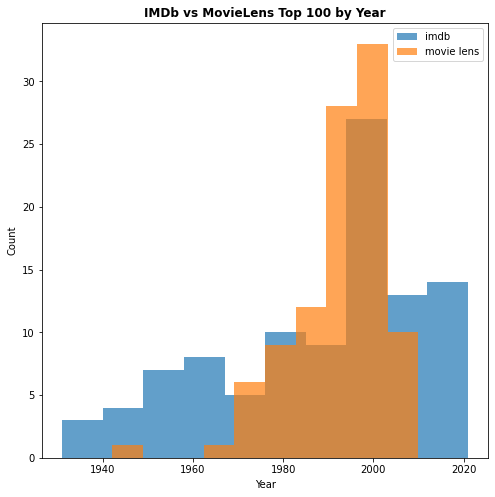

In [42]:
plt.figure(figsize=(8,8))
plt.hist(imdb_top100['year'], label='imdb', alpha=.7)
plt.hist(df_top100['year'], label='movie lens', alpha=.7)
plt.legend(loc='upper right')
plt.title('IMDb vs MovieLens Top 100 by Year',  fontweight='bold')
plt.xlabel('Year', labelpad=5)
plt.ylabel('Count', labelpad=5)
#plt.savefig('Visuals/top_100', facecolor='w', transparent=False, dpi = 1000, bbox_inches='tight')
plt.show()

## How compare to imdb's top 250?

In [29]:
df_top250 = [title for title in popular_movies['title'].head(250)]
intersection(df_top250, all_titles_imdb)

['Fight Club (1999)',
 'Pulp Fiction (1994)',
 'Forrest Gump (1994)',
 "Schindler's List (1993)",
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Saving Private Ryan (1998)',
 'Goodfellas (1990)',
 'American History X (1998)',
 "One Flew Over the Cuckoo's Nest (1975)",
 'Reservoir Dogs (1992)',
 'Fargo (1996)',
 'Memento (2000)',
 'Monty Python and the Holy Grail (1975)',
 'Eternal Sunshine of the Spotless Mind (2004)',
 'Braveheart (1995)',
 'American Beauty (1999)',
 'Apocalypse Now (1979)',
 'Casablanca (1942)',
 'Back to the Future (1985)',
 'Good Will Hunting (1997)',
 'Inception (2010)',
 'Blade Runner (1982)',
 'Terminator 2: Judgment Day (1991)',
 'Indiana Jones and the Last Crusade (1989)',
 'Taxi Driver (1976)',
 'Full Metal Jacket (1987)',
 'Toy Story (1995)',
 'WALL·E (2008)',
 'Alien (1979)',
 'Gladiator (2000)',
 'Trainspotting (1996)',
 'Finding Nemo (2003)',
 'Groundhog Day (1993)',
 'Aliens (1986)',
 'Up

In [30]:
print(f'Percent of overlapping top 250: {len(intersection(df_top250, all_titles_imdb))}%')

Percent of overlapping top 250: 45%


In [31]:
df_top250 = popular_movies.copy()[['title', 'year', 'weighted_avg']].head(250)
df_top250['year'] = df_top250['year'].astype(int)

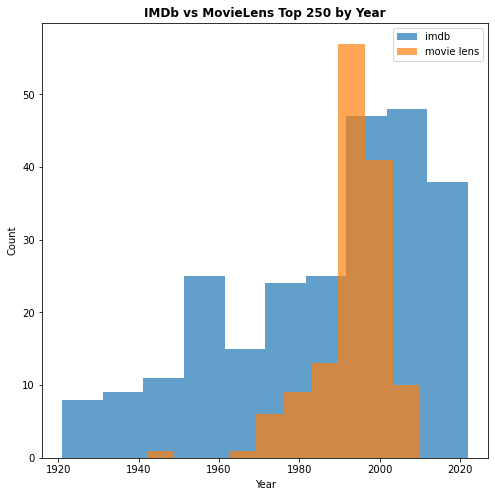

In [43]:
plt.figure(figsize=(8,8))
plt.hist(imdb['year'], label='imdb', alpha=.7)
plt.hist(df_top250['year'], label='movie lens', alpha=.7)
plt.legend(loc='upper right')
plt.title('IMDb vs MovieLens Top 250 by Year',  fontweight='bold')
plt.xlabel('Year', labelpad=5)
plt.ylabel('Count', labelpad=5);
#plt.savefig('Visuals/top_250', facecolor='w', transparent=False, dpi = 1000, bbox_inches='tight')